# Image classification: cats & dogs

In [1]:
# Handle imports up-front
import glob
import random
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image

2024-12-09 23:56:21.858316: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Data Preparation

### 1.1. Load the data paths

In [2]:
# Set the path to the training data
training_data_path='../data/train'

# Get a list of training dog and cat images
training_dogs=glob.glob(f'{training_data_path}/dog/dog.*')
training_cats=glob.glob(f'{training_data_path}/cat/cat.*')

# Set the path to the test data
testing_data_path='../data/test1'

### 1.2. Inspect training data

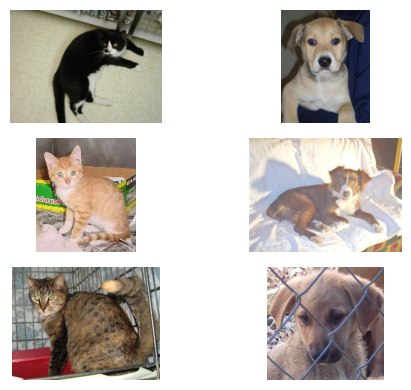

In [3]:
# Plot some of the cat and dog images
fig, axs = plt.subplots(3,2,figsize=(6, 4))

for cat, dog, row in zip(training_cats, training_dogs, axs):
    for animal, ax in zip([cat, dog], row):
        animal=image.load_img(animal)
        animal=image.img_to_array(animal)
        animal/=255.0
        ax.imshow(animal)
        ax.axis('off')

plt.tight_layout()
plt.show()

## 2. EDA

### 2.1. Image data

In [4]:
# Load one of the images as an array and look at it's shape - what do you see, what are the dimensions? Are they what you expect?

# Load one of the dogs
dog=image.load_img(training_dogs[0])

# And convert it to an array - this is how TensorFlow will handel the data
dog=image.img_to_array(dog)

# Take a look at some properties of the object
print(f'Image data is: {type(dog)}')
print(f'Image data shape: {dog.shape}')

Image data is: <class 'numpy.ndarray'>
Image data shape: (500, 390, 3)


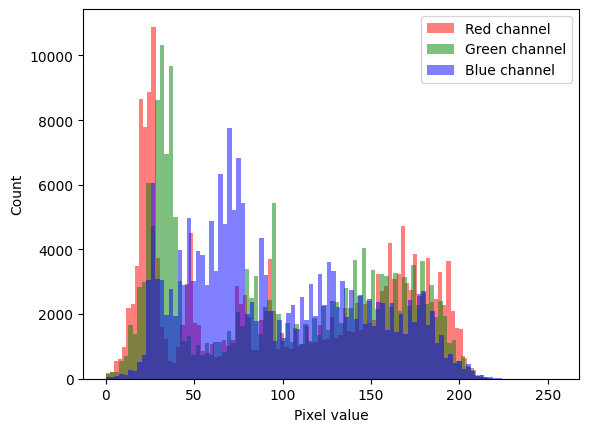

In [5]:
# Plot a histogram of the three 2D arrays which comprise the image. What do you see?

plt.hist(dog[:,:,0].flatten(), bins=100, color='red', alpha=0.5, label='Red channel')
plt.hist(dog[:,:,1].flatten(), bins=100, color='green', alpha=0.5, label='Green channel')
plt.hist(dog[:,:,2].flatten(), bins=100, color='blue', alpha=0.5, label='Blue channel')
plt.xlabel('Pixel value')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

### 2.2. Image dimensions


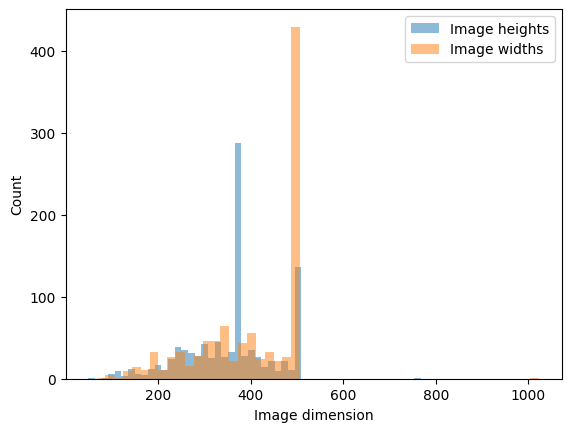

In [6]:
# Loop over a few hundred images and extract their width and heigh, plot both as a histogram. What do you see, does this information matter to us, if so, how?

sample_size=1000
sample=random.sample(training_dogs, sample_size//2)
sample+=random.sample(training_cats, sample_size//2)

heights=[]
widths=[]

for sample_image in sample:

    sample_image=image.load_img(sample_image)
    sample_image=image.img_to_array(sample_image)
    heights.append(sample_image.shape[0])
    widths.append(sample_image.shape[1])

plt.hist(heights, bins=50, alpha=0.5, label='Image heights')
plt.hist(widths, bins=50, alpha=0.5, label='Image widths')
plt.xlabel('Image dimension')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

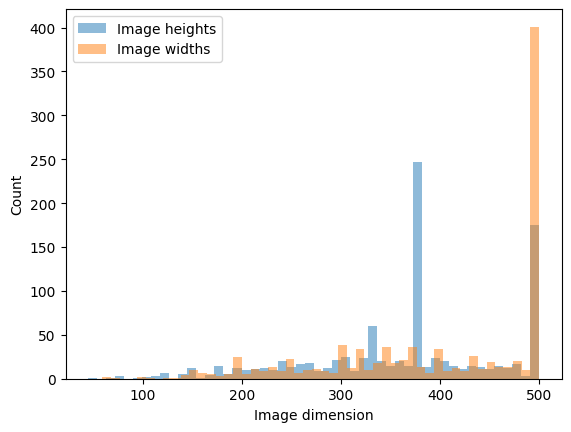

In [7]:
sample_size=1000
sample=random.sample(training_dogs, sample_size//2)
sample+=random.sample(training_cats, sample_size//2)

heights=[]
widths=[]

image_dim = 128

for sample_image in sample:

    sample_image=image.load_img(sample_image)
    sample_image=image.img_to_array(sample_image)
    heights.append(sample_image.shape[0])
    widths.append(sample_image.shape[1])

plt.hist(heights, bins=50, alpha=0.5, label='Image heights')
plt.hist(widths, bins=50, alpha=0.5, label='Image widths')
plt.xlabel('Image dimension')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

### 2.3. Image aspect ratios

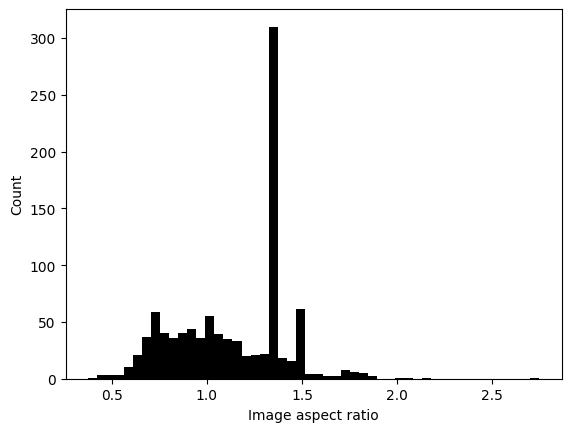

In [8]:
# Plot a histogram of the image aspect ratios (i.e. width/height) What do you see, does this information matter to us, if so, how?

# Calculate the sample image aspect ratios
aspect_ratios=np.array(widths)/np.array(heights)

# Plot as histogram
plt.hist(aspect_ratios, bins=50, color='black')
plt.xlabel('Image aspect ratio')
plt.ylabel('Count')
plt.show()

## 3. Build the model

### 3.1. Prepare images for streaming

In [9]:
def make_datasets(training_data_path: str, image_dim: int, batch_size: int=16):

    training_dataset=tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='training',
        seed=315,
        image_size=(image_dim, image_dim),
        batch_size=batch_size
    ).repeat()

    validation_dataset=tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='validation',
        seed=315,
        image_size=(image_dim, image_dim),
        batch_size=batch_size
    ).repeat()



    return training_dataset, validation_dataset,


training_dataset, validation_dataset=make_datasets(training_data_path, 128)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


### 3.1. Model definition

In [10]:
def compile_model(image_dim, learning_rate):

    initializer=tf.keras.initializers.GlorotUniform(seed=315)

    model=Sequential([
        layers.Input((image_dim, image_dim, 3)),
        layers.Rescaling(1./255),
        layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(1, activation='sigmoid', kernel_initializer=initializer)
    ])

    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])

    return model

model=compile_model(128, 0.001)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,120,993 (8.09 MB)

 Trainable params: 2,120,993 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2. Model training

In [11]:
training_results=model.fit(
  training_dataset,
  validation_data=validation_dataset,
  epochs=10,
  steps_per_epoch=5,
  validation_steps=5
)

Epoch 1/10
1/5 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - binary_accuracy: 0.1875 - loss: 0.7145

2024-12-10 00:02:19.154550: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24772608 exceeds 10% of free system memory.
2024-12-10 00:02:19.192628: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25952256 exceeds 10% of free system memory.
2024-12-10 00:02:19.326653: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24772608 exceeds 10% of free system memory.
2024-12-10 00:02:19.352816: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25952256 exceeds 10% of free system memory.


3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - binary_accuracy: 0.3611 - loss: 0.8203

2024-12-10 00:02:19.492739: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24772608 exceeds 10% of free system memory.


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - binary_accuracy: 0.4035 - loss: 0.8347 - val_binary_accuracy: 0.4500 - val_loss: 0.7030
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - binary_accuracy: 0.4630 - loss: 0.7006 - val_binary_accuracy: 0.6375 - val_loss: 0.6919
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - binary_accuracy: 0.5818 - loss: 0.6902 - val_binary_accuracy: 0.5125 - val_loss: 0.6924
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - binary_accuracy: 0.4866 - loss: 0.7035 - val_binary_accuracy: 0.4750 - val_loss: 0.7002
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - binary_accuracy: 0.3938 - loss: 0.7080 - val_binary_accuracy: 0.4500 - val_loss: 0.6939
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - binary_accuracy: 0.4877 - loss: 0.6919 - val_binary_accuracy: 0.5375 - val_loss: 0.6941
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - binary_accuracy: 0.5509 - loss: 0.6901 - val_binary_accuracy: 0.4875 - val_loss: 0.6922
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━

In [12]:
print(training_results.history.keys())

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])


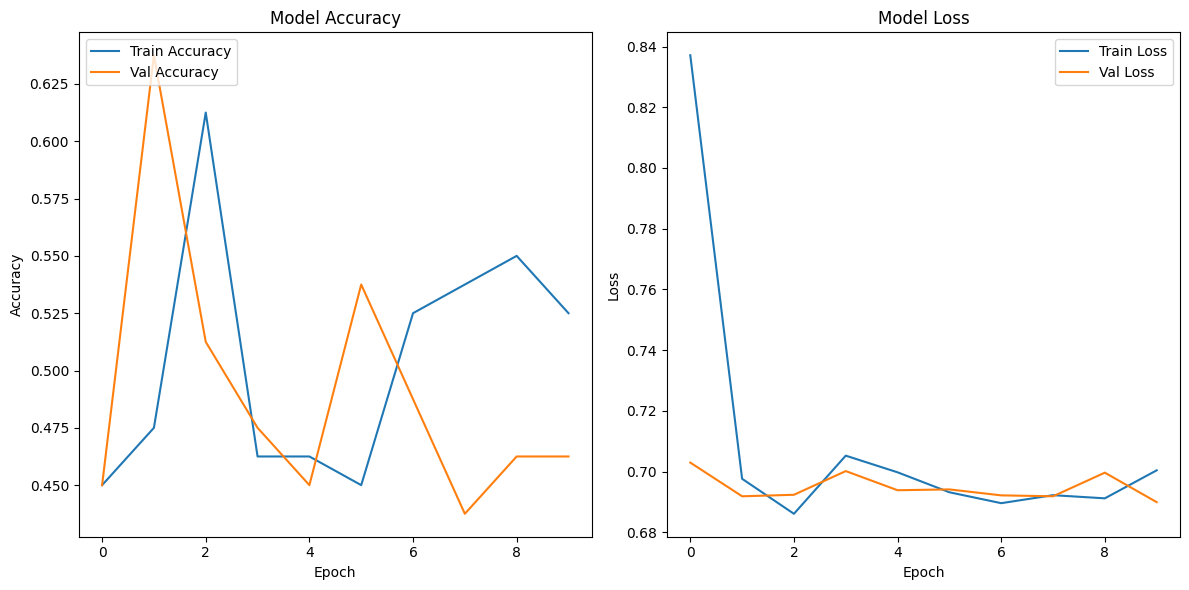

In [13]:
# Take a look at what information 'training_results' contains. Plot the training and validation accuracy (and binary cross-entropy if you like) over the training epoch. Is the model learning? If not, what do you think is wrong?

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_results.history['binary_accuracy'], label='Train Accuracy')
plt.plot(training_results.history['val_binary_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(training_results.history['loss'], label='Train Loss')
plt.plot(training_results.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### 3.3. Model optimization

In [15]:
learning_rates = [0.1, 0.01, 0.001]
batch_size = [16, 32, 64]
results = []

training_data_path = '../data/train'

for lr in learning_rates:
    for bs in batch_size:
        
        training_dataset, validation_dataset = make_datasets(training_data_path, image_dim=128, batch_size=bs)

       
        model = compile_model(image_dim=128, learning_rate=lr)

       
        result = model.fit(training_dataset, validation_data=validation_dataset, epochs=10, steps_per_epoch=5, validation_steps=5)

       
        results.append((lr, bs, result))

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - binary_accuracy: 0.4264 - loss: 8228.7246 - val_binary_accuracy: 0.4500 - val_loss: 0.7257
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - binary_accuracy: 0.5332 - loss: 7.2905 - val_binary_accuracy: 0.5125 - val_loss: 0.7728
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - binary_accuracy: 0.3719 - loss: 0.8213 - val_binary_accuracy: 0.4875 - val_loss: 0.6947
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - binary_accuracy: 0.4349 - loss: 0.7063 - val_binary_accuracy: 0.4750 - val_loss: 0.7294
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - binary_accuracy: 0.3938 - loss: 0.7634 - val_binary_accuracy: 0.4500 - val_loss: 0.7008
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - binary_accuracy: 0.5127 - loss: 0.6908 - val_binary_accuracy: 0.4625 - val_loss: 0.7058
Epoch 7/

## 4. Evaluate the model

In [16]:
for lr, bs, result in results:
    print(f'Learning Rate: {lr}, Batch Size: {bs}')
    print(f'Train Accuracy: {result.history["binary_accuracy"][-1]}')
    print(f'Validation Accuracy: {result.history["val_binary_accuracy"][-1]}')

Learning Rate: 0.1, Batch Size: 16
Train Accuracy: 0.5249999761581421
Validation Accuracy: 0.4625000059604645
Learning Rate: 0.1, Batch Size: 32
Train Accuracy: 0.4937500059604645
Validation Accuracy: 0.48750001192092896
Learning Rate: 0.1, Batch Size: 64
Train Accuracy: 0.4937500059604645
Validation Accuracy: 0.5
Learning Rate: 0.01, Batch Size: 16
Train Accuracy: 0.5249999761581421
Validation Accuracy: 0.4625000059604645
Learning Rate: 0.01, Batch Size: 32
Train Accuracy: 0.4937500059604645
Validation Accuracy: 0.512499988079071
Learning Rate: 0.01, Batch Size: 64
Train Accuracy: 0.5062500238418579
Validation Accuracy: 0.5
Learning Rate: 0.001, Batch Size: 16
Train Accuracy: 0.5249999761581421
Validation Accuracy: 0.4625000059604645
Learning Rate: 0.001, Batch Size: 32
Train Accuracy: 0.53125
Validation Accuracy: 0.6187499761581421
Learning Rate: 0.001, Batch Size: 64
Train Accuracy: 0.668749988079071
Validation Accuracy: 0.6156250238418579
